# **"Методи прийняття рішень"**

## Завдання

### **Мета**

Маючи вхідний набір даних, опрацювати його, розв’язати задачу прогнозування ціни оренди нерухомості, описати свої дії у презентації.

Рішення міститиме **Jupyter Notebook** та презентацію. Тут описані вимоги до **Jupyter Notebook**.

### **Вимоги**
Розв’язок має складатися з 3-х основних частин:
1. Аналіз та підготовка даних.
2. Моделювання.
3. Аналіз результатів.


**Частина 1. Аналіз та підготовка даних**

- Проаналізуй діапазони значень, їх середні та дисперсію, розподіли, кореляції, наявність пропущених значень, типи ознак.
- Перевір на наявність пропущених значень. За наявності заповни їх або видали рядки з пропусками.
- За наявності бінарних ознак заміни значення цих ознак на 0 та 1.
- За потреби певні дані можуть бути видалено або модифіковано.

**Частина 2. Моделювання**

- Створи як мінімум 2 різні регресійні моделі для прогнозування цільової змінної “Rent”. 
- Моделі вважаються різними, якщо вони базуються на різних даних або є різними типами моделей.
- Оціни якість моделей як мінімум за 2 метриками.
- Оцінка має бути проведена або на тестовій вибірці, або за допомогою крос-валідації.

**Частина 3. Аналіз результатів**

- Для всіх моделей побудуй графіки порівняння справжніх та спрогнозованих даних.
- Зроби висновки, на яких прикладах кожна модель більше помиляється.
- Зроби порівняння якості моделей. Напиши висновки.

**Додатково**
- Проаналізуй ознаки на мультиколінеарність (Variance inflation factor).
- Знайди оптимальні значення параметрів моделей, наприклад, за допомогою алгоритму GridSearch.
- Проаналізуй важливість ознак (feature importance).
- Побудуй графік залишків (residuals plot).

### **Джерело даних** 

[**Датасет "House Rent Prediction Dataset”:**](https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/edit?gid=881312933#gid=881312933)

https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/edit?gid=881312933#gid=881312933

## **ЧАСТИНА 1: *Аналіз та підготовка даних***

### Отримання даних з посилання на Google Sheets

У зв'язку з тим, що початковий документ, посилання на який дано в завданні, містить різні аркуші, було вирішено почати підготовку даних з пошуку та завантаження саме того аркушу, що містить у назві ключові слова. Для цього було розроблено скрипт на Python, який автоматизує цей процес.

**Функція `find_csv_link_by_keywords`**

Ця функція приймає URL на Google Sheets документ та список ключових слів. Вона здійснює такі кроки:
1. Завантажує HTML-код сторінки за вказаним URL.
2. Парсить HTML-код для пошуку назв аркушів у документі.
3. Перевіряє, чи містять назви аркушів вказані ключові слова.
4. Якщо знаходиться відповідний аркуш, функція формує URL для експорту цього аркуша у форматі `.csv` і повертає цей URL. Якщо аркуш не знайдено, повертається повідомлення про помилку.

**Функція `get_spreadsheet_id`**

Ця допоміжна функція витягує ідентифікатор документа з URL-адреси Google Sheets. Вона використовується в `find_csv_link_by_keywords` для правильного формування URL на `.csv` документ.

**Функція `is_csv_url`**

Перевіряє, чи вказує передана URL-адреса на `.csv` документ. Вона надсилає HTTP-запит типу HEAD до URL і аналізує заголовок `Content-Type`. Якщо заголовок вказує на тип `text/csv`, функція повертає `True`, інакше `False`. Це дозволяє уникнути помилок при завантаженні даних з неправильного формату.


In [324]:
import urllib.parse

import pandas as pd
import requests
from bs4 import BeautifulSoup


def find_csv_link_by_keywords(url: str, keywords: list) -> str:
    """
    Функція приймає URL на Google Sheets документ і список ключових слів.
    Повертає посилання на .csv-документ, що містить дані, пов'язані з цими ключовими словами.

    Parameters
    ----------
    url : str
        URL на Google Sheets документ.
    keywords : list of str
        Список ключових слів для пошуку.

    Returns
    -------
    str
        URL на .csv файл або повідомлення про помилку.
    """
    try:
        # Отримуємо HTML сторінки за допомогою HTTP запиту
        response = requests.get(url)

        # Перевіряємо, чи успішний запит (код 200 означає успіх)
        if response.status_code != 200:
            return f"Помилка доступу до URL: {response.status_code}"

        # Використовуємо BeautifulSoup для парсингу HTML-коду сторінки
        soup = BeautifulSoup(response.text, "html.parser")

        # Збираємо всі назви аркушів (вони зберігаються в <div> з класом 'docs-sheet-tab')
        sheet_titles = [
            div.get_text() for div in soup.find_all("div", class_="docs-sheet-tab")
        ]

        # Перебираємо всі назви аркушів і перевіряємо, чи містять вони ключові слова
        for title in sheet_titles:
            for keyword in keywords:
                # Якщо ключове слово є в назві аркуша (незалежно від регістру)
                if keyword.lower() in title.lower():
                    # Формуємо URL для експорту аркуша у форматі .csv
                    csv_url = (
                        f"https://docs.google.com/spreadsheets/d/"
                        f"{get_spreadsheet_id(url)}/gviz/tq?tqx=out:csv&sheet="
                        f"{urllib.parse.quote(title)}"
                    )
                    return csv_url

        # Якщо жоден аркуш не відповідає ключовим словам, повертаємо повідомлення
        return "Не знайдено аркушів, що відповідають ключовим словам."

    except Exception as e:
        # Якщо виникла будь-яка інша помилка, повертаємо її опис
        return f"Сталася помилка: {str(e)}"


def get_spreadsheet_id(url: str) -> str:
    """
    Функція для витягування ID документа з URL.

    Parameters
    ----------
    url : str
        URL на Google Sheets документ.

    Returns
    -------
    str
        ID документа.

    Raises
    ------
    ValueError
        Якщо не вдалося витягти ID документа з URL.
    """
    # Парсимо URL для отримання окремих частин
    parsed_url = urllib.parse.urlparse(url)
    path_parts = parsed_url.path.split("/")

    # Ідентифікатор документа знаходиться між 'd' і наступним елементом у URL
    if "d" in path_parts:
        return path_parts[path_parts.index("d") + 1]
    else:
        # Якщо структура URL не відповідає очікуваній, генеруємо помилку
        raise ValueError("Не вдалося витягти ID документа з URL.")


def is_csv_url(url: str) -> bool:
    """
    Функція перевіряє, чи вказує передана URL-адреса на .csv-документ.

    Parameters
    ----------
    url : str
        URL для перевірки.

    Returns
    -------
    bool
        True, якщо URL вказує на .csv документ, інакше False.
    """
    try:
        # Здійснюємо запит до URL
        response = requests.head(url, allow_redirects=True)

        # Перевіряємо заголовки, зокрема Content-Type
        content_type = response.headers.get("Content-Type", "")

        # Повертаємо True, якщо Content-Type вказує на CSV
        return "text/csv" in content_type
    except Exception as e:
        print(f"Помилка при перевірці URL: {str(e)}")
        return False


# Тестування функції
keywords = ["house", "rent"]
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/edit?gid=881312933#gid=881312933"
csv_link = find_csv_link_by_keywords(spreadsheet_url, keywords)
print(f'Результат роботи функції "find_csv_link_by_keywords": {csv_link}')

print(f'Перевірка отриманого посилання: {csv_link.startswith("http")}')
# Перевірка, чи URL вказує на .csv файл
if is_csv_url(csv_link):
    # Завантажуємо дані у DataFrame за допомогою pandas
    df = pd.read_csv(csv_link)
    # Виводимо перші 5 рядків таблиці для перевірки
    print(df.head())
else:
    print("Помилка: не вдалося завантажити дані.")



Результат роботи функції "find_csv_link_by_keywords": https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/gviz/tq?tqx=out:csv&sheet=House_Rent_Dataset
Перевірка отриманого посилання: True
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4        

### Аналіз та підготовка даних

#### Завантаження та попередній огляд даних

Спершу завантажимо набір даних і подивимося на перші кілька рядків, щоб зрозуміти структуру та зміст даних.
Для завантаження скористаємось функцією `find_csv_link_by_keywords`, створеною раніше.

In [325]:
keywords = ["house", "rent"]
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/edit?gid=881312933#gid=881312933"
csv_link = find_csv_link_by_keywords(spreadsheet_url, keywords)

# Виведення перших 5 рядків (за замовчуванням) набору даних
print("Перші кілька рядків даних:")
print(df.head())


Перші кілька рядків даних:
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3

#### Перевірка на наявність пропущених значень

Далі перевіримо, чи є в наборі даних пропущені значення. Це важливо, оскільки пропущені значення можуть вплинути на точність моделі прогнозування.

In [326]:
# Перевірка на наявність пропущених значень
missing_values = df.isnull().sum()

# Виведення кількості пропущених значень для кожного стовпчика
print("\nКількість пропущених значень у кожному стовпчику:")
print(missing_values)


Кількість пропущених значень у кожному стовпчику:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


Згідно з результатами, в наборі даних пропущених значеннь на виявлено.

У разі, якщо пропущені дані було знайдено, можна було б:
1. Заповнити відсутні комірки (для числових даних):
   - середніми значеннями,
   - медіаною,
   - або модою.
2. Передбачити їх на основі інших змінних.
3. Видалити рядки з пропущеними значеннями. 

#### Описова статистика та аналіз розподілів

Переглянемо основні статистичні показники для кожного стовпчика даних. Це дозволить зрозуміти діапазони значень, середні, дисперсії та стандартні відхилення. Ці дані допоможуть зрозуміти розподіли числових змінних, знайти можливі аномалії або невідповідності, а також побачити, які змінні є числовими, а які — категоріальними.

In [327]:
# Перевірка типів даних
print("\nТипи даних у наборі:")
print(df.dtypes)

# Описова статистика для числових стовпців
print("\nОписова статистика для числових стовпців:")
print(df.describe())


Типи даних у наборі:
Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

Описова статистика для числових стовпців:
               BHK          Rent         Size     Bathroom
count  4746.000000  4.746000e+03  4746.000000  4746.000000
mean      2.083860  3.499345e+04   967.490729     1.965866
std       0.832256  7.810641e+04   634.202328     0.884532
min       1.000000  1.200000e+03    10.000000     1.000000
25%       2.000000  1.000000e+04   550.000000     1.000000
50%       2.000000  1.600000e+04   850.000000     2.000000
75%       3.000000  3.300000e+04  1200.000000     2.000000
max       6.000000  3.500000e+06  8000.000000    10.000000


### Ковертація дати в числовий формат

Звернемо увагу на те, що колонка "Posted On" у наборі даних містить дати і має тип `object`. Дані про дату публікації можуть бути корисними для аналізу, наприклад, для виявлення сезонних трендів, наприклад, збільшення попиту у святкові періоди. Щоб врахувати ці фактори, ми можемо перетворити кожну дату на "день року" (наприклад, 1 січня буде 1, а 31 грудня - 365 або 366 у високосний рік). Це дозволить включити інформацію про сезонність в моделювання.

In [328]:
# Перетворюємо колонку "Posted On" у формат datetime
df['Posted On'] = pd.to_datetime(df['Posted On'], format='%Y-%m-%d')
df['DayOfYear'] = df['Posted On'].dt.dayofyear  # Отримуємо день року

# Видаляємо оригінальний стовпчик дати, для якого ми вже створили новий стовпчик
df.drop('Posted On', axis=1, inplace=True)

# Перевірка типів даних
print("\nТипи даних у наборі після перетворення:")
print(df.dtypes)

# Виведення випадкових 5 рядків даних для перевірки
print("\nВипадкові 5 рядків даних:")
print(df.sample(5))


Типи даних у наборі після перетворення:
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
DayOfYear             int32
dtype: object

Випадкові 5 рядків даних:
      BHK   Rent  Size            Floor    Area Type      Area Locality  \
1409    2  29000   670       7 out of 7  Carpet Area         Amar Nagar   
2879    1  21000   100  Ground out of 1   Super Area  Chittaranjan Park   
3018    2  15000  1500  Ground out of 1   Super Area       Madanankppam   
1971    1   6000   150       3 out of 4   Super Area       Malleshwaram   
2140    2   8500   532       1 out of 2  Carpet Area       Tannery Road   

           City Furnishing Status  Tenant Preferred  Bathroom  \
1409     Mumbai       Unfurnished            Family         2   
2

#### Перетворення "Size" та "Area Type"

При оцінці нерухомості важливо розуміти різницю між трьома основними типами площ: *Carpet Area*, *Built-Up Area* та *Super Area*. **Carpet Area** - це фактична житлова площа, яку можна використовувати, і вона є найважливішим показником для орендарів та покупців. **Built-Up Area** включає Carpet Area плюс товщину стін та колон, тоді як **Super Area** є найбільшою і включає також спільні зони будівлі.
Попри те, що для точних розрахунків рекомендується звертатися до офіційної документації або консультуватися з місцевими експертами з нерухомості, можна намагатися наблизити ці значення на основі відомих відсотків, а саме:
**Carpet Area** - близько 70-75% від **Super Area** або 85-90% від **Built-Up Area**.
Використаємо ці дані, щоб позбутися ознаки 'Area Type' типу `object`, застосувавши відповідні коефіцієнти до значень в колонці "Size" та привівши її в один тип площі, що підвищить цінність цієї ознаки для моделювання та покращить його точність.

In [329]:
# Створюємо функцію для перетворення площі
def convert_to_carpet_area(row):
    if row['Area Type'] == 'Carpet Area':
        return row['Size']
    elif row['Area Type'] == 'Built-Up Area':
        return row['Size'] * 0.875
    elif row['Area Type'] == 'Super Area':
        return row['Size'] * 0.725
    else:
        return row['Size']  # Якщо тип невідомий, залишаємо як є

# Застосовуємо перетворення до всіх рядків
df['Size_Carpet'] = df.apply(convert_to_carpet_area, axis=1)

# Видаляємо оригінальні стовпці, якщо вони більше не потрібні
df.drop(columns=['Size', 'Area Type'], inplace=True)

# Виведення випадкових 5 рядків для перевірки
print("\nВипадкові 5 рядків даних після перетворення площі:")
print(df.sample(5))


Випадкові 5 рядків даних після перетворення площі:
      BHK   Rent            Floor                     Area Locality  \
447     2  10000  Ground out of 3                           Sodepur   
1437    1   7500      3 out of 12  Sumit Greendale, Chikhal Dongari   
4691    3  20000       2 out of 5                    New Mallepally   
3957    2   9500       2 out of 3         Bollaram, Outer Ring Road   
2181    2   9500       4 out of 5             Nagvarpalya Main Road   

           City Furnishing Status  Tenant Preferred  Bathroom  \
447     Kolkata    Semi-Furnished  Bachelors/Family         2   
1437     Mumbai    Semi-Furnished  Bachelors/Family         2   
4691  Hyderabad    Semi-Furnished  Bachelors/Family         3   
3957  Hyderabad       Unfurnished  Bachelors/Family         2   
2181  Bangalore    Semi-Furnished  Bachelors/Family         2   

     Point of Contact  DayOfYear  Size_Carpet  
447     Contact Owner        152       870.00  
1437    Contact Agent        183  

#### Перетворення бінарних змінних

Спробуємо знайти в наборі даних бінарні змінні та перетворити їх на числові. Це потрібно для подальшого аналізу та моделювання.
Для цього переглянемо унікальні значення кожного стовпчика та визначимо, які з них можна вважати бінарними.

In [330]:
df.nunique()

BHK                     6
Rent                  243
Floor                 480
Area Locality        2235
City                    6
Furnishing Status       3
Tenant Preferred        3
Bathroom                8
Point of Contact        3
DayOfYear              81
Size_Carpet           810
dtype: int64

Як бачимо, в наборі даних немає бінарних змінних, але є ознаки, що мають невелику кількість унікальних значеннь.
Розглянемо їх окремо та вирішимо, як їх краще перетворити для подальшого аналізу.

##### *Ознаки з **трьома** унікальними значеннями*

Наступні ознаки мають по три унікальних значення:

- **Furnishing Status**
- **Tenant Preferred**
- **Point of Contact**

Кожна з цих ознак може мати вплив на цільову змінну "Rent", тому їх слід перетворити на числові для подальшого аналізу та моделювання.
Ці ознаки можуть бути зведені до бінарних значень або закодовані за допомогою методу "one-hot encoding". Наприклад, ознаку **Furnishing Status** можна перетворити на три бінарні змінні: `Is_Unfurnished`, `Is_Semi_Furnished`, `Is_Furnished`. Це дозволить ефективніше працювати з цими змінними в моделях машинного навчання, зокрема, у регресійних моделях, де потрібно обробляти категоріальні змінні як числові.

**One-Hot Encoding**: Це метод перетворення категоріальних змінних у числові, при якому кожне унікальне значення категоріальної змінної перетворюється в окрему бінарну змінну. Цей підхід дозволяє уникнути порядкової інтерпретації категорій, що може бути корисним у моделях машинного навчання.

Щоб застосувати метод "One-Hot Encoding" до, ви скористаємось функцією `pd.get_dummies()` із бібліотеки `pandas`. Цей метод дозволяє перетворити категоріальні змінні на бінарні, де кожна категорія перетворюється в окрему колонку.

Зауважимо, що опція `drop_first=True` вказує на те, щоб уникнути пастки фіктивних змінних ("dummy variable trap"), тобто автоматично видалити одну з нових бінарних колонок для кожної категоріальної змінної. Це знижує [**мультиколінеарність**](https://uk.wikipedia.org/wiki/Мультиколінеарність) у регресійних моделях.

In [331]:
# Вибираємо категоріальні колонки, до яких хочемо застосувати One-Hot Encoding
categorical_columns = ['Furnishing Status', 'Tenant Preferred', 'Point of Contact']

# Застосовуємо One-Hot Encoding до обраних колонок
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Для зручності переіменовуємо нові стовпці
df.rename(columns={
    'Point of Contact_Contact Owner': 'Owner_Contacted',
    'Furnishing Status_Semi-Furnished': 'Semi_Furnished',
    'Furnishing Status_Unfurnished': 'Unfurnished',
    'Tenant Preferred_Bachelors/Family': 'Bachelors_Family',
    'Tenant Preferred_Family': 'Family',
    'Point of Contact_Contact Builder': 'Builder_Contacted',
    'Point of Contact_Contact Owner': 'Owner_Contacted'
}, inplace=True)

##### *Перетворення ознаки **"City"***

Ознака "City" має 6 унікальних значень. Це категоріальна змінна, яка без сумніву впливає на цільову змінну "Rent". Щоб врахувати цю ознаку у моделі, її також слід перетворити на числові значення. Ми отримаємо 6 нових бінарних змінних, кожна з яких — це назва міста. Це дозволить моделі розрізняти між різними містами та їх впливом на цільову змінну.

In [332]:
# Спершу переглянемо унікальні значення у колонці 'City'
print(df['City'].unique())

# Застосування One-Hot Encoding до колонки 'City'
df = pd.get_dummies(df, columns=['City'], drop_first=True)

['Kolkata' 'Mumbai' 'Bangalore' 'Delhi' 'Chennai' 'Hyderabad']


##### *Перетворення ознаки **"Floor"***

Як ми бачили раніше, ознака "Floor" містить 480 унікальних значень. Аналіз цих значень показує, що вони містять різноманітні формати запису, включаючи номери поверхів, спеціальні позначення ("Ground", "Upper Basement", "Lower Basement"), та відношення (наприклад, "5 out of 12" означає, що приміщення розташоване на 5-му поверсі в будівлі з 12 поверхами). 

Для подальшої обробки цієї колонки можна застосувати такі підходи:

1. **Створення двох окремих колонок**

Розділимо колонку на дві частини:

- **"Floor_Number"**: Номер поверху, на якому знаходиться приміщення.
- **"Total_Floors"**: Загальна кількість поверхів у будівлі.

Для цього напишемо код, який виділяє числові значення з рядка і перетворює їх у відповідні колонки. Якщо поверх позначений як "Ground", "Upper Basement", або "Lower Basement", можна закодувати ці значення як -1, 0 та -2 відповідно для "Floor_Number".

2. **Перетворення категоріальних значень в числові**

Такі значення, як "Ground", "Upper Basement", "Lower Basement", можна перетворити на числові:

- "Ground" = 0
- "Upper Basement" = -1
- "Lower Basement" = -2

Це дасть змогу використати ці значення в моделях, що вимагають числових даних.

3. **Заповнення пропущених даних**

Наявність порожніх значень у DataFrame може призвести до проблем у подальшому аналізі та моделюванні. Заповнення пропущених даних — важлива частина підготовки даних, і те, як ми це зробимо, може значно вплинути на результати моделювання.

Часто для заповнення пропущених значень використовують такі методи, як середнє значення, медіана, мода, або значення, що зустрічається найчастіше. Однак у нашому випадку, для даних про поверхи, такий підхід може бути неоптимальним і нелогічним. 

Натомість використаємо наступний підхід:
- Якщо не вдалось знайти значення для Floor_Number, можна задати значення 0, що буде означати, що поверх невідомий або що це приміщення на землі, а не у багатоповерхівці.
- У випадку, якщо немає інформації про кількість поверхів, можна прирівняти значення Total_Floors до значення Floor_Number. Це буде означати, що відсутність інформації прирівнюється до того, що цей поверх є єдиним у будинку.

Код для описаних та додаткових операцій для підготовки даних ознаки "Floor" наведено нижче.
Після виконання цих операцій ми отримаємо дві нові колонки: "Floor_Number" та "Total_Floors", які можна використовувати для подальшого аналізу та моделювання замість оригінальної колонки "Floor", яку можна видалити без втрати інформації.
Для перевірки результатів виведемо випадкові 25 рядків нового DataFrame.

In [333]:
# Функція для розділення значень на номер поверху та загальну кількість поверхів
def split_floor(floor_value):
    if "Ground" in floor_value:
        if "out of" in floor_value:
            return 0, int(floor_value.split(" out of ")[-1])
        else:
            return 0, 1  # Якщо немає інформації про кількість поверхів, вважаємо, що це єдиний поверх
    elif "Upper Basement" in floor_value:
        return -1, int(floor_value.split(" out of ")[-1])
    elif "Lower Basement" in floor_value:
        return -2, int(floor_value.split(" out of ")[-1])
    elif "out of" in floor_value:
        return int(floor_value.split(" out of ")[0]), int(floor_value.split(" out of ")[-1])
    else:
        try:
            floor_num = int(floor_value)
            return floor_num, floor_num  # Якщо немає інформації про кількість поверхів, прирівнюємо до номера поверху
        except ValueError:
            return 0, 0  # Якщо значення взагалі не вдалося знайти, задаємо 0 як індикатор невідомих даних

# Застосування функції до колонки "Floor"
df['Floor_Number'], df['Total_Floors'] = zip(*df['Floor'].map(split_floor))

# Виведення випадкових 25 рядків для перевірки
print(df[['Floor', 'Floor_Number', 'Total_Floors']].sample(25))

# Видалення колонки "Floor"
df = df.drop(columns=['Floor'])

                        Floor  Floor_Number  Total_Floors
4226          Ground out of 1             0             1
1671               1 out of 4             1             4
4736  Lower Basement out of 2            -2             2
1800               4 out of 5             4             5
1000             18 out of 22            18            22
1288              5 out of 20             5            20
1214              5 out of 16             5            16
979                3 out of 9             3             9
2141               1 out of 4             1             4
2953               1 out of 4             1             4
536                2 out of 4             2             4
2672               2 out of 3             2             3
1459             24 out of 24            24            24
2658          Ground out of 4             0             4
467           Ground out of 2             0             2
811              21 out of 22            21            22
1084          

##### *Перетворення ознаки **"Area Locality"***

Фраза, яку часто приписують британському магнату нерухомості [***Гарольду Семюелю***](https://en.wikipedia.org/wiki/Harold_Samuel,_Baron_Samuel_of_Wych_Cross), може бути відома багатьом:

> *"У нерухомості є три найважливіші речі: розташування, розташування і розташування."*

Дані, що ми маємо, містять цінну інформацію про райони, в яких розташовані приміщення. Але відповідна ознака — "Area Locality" має 2235 унікальних значення. Використання *One-Hot Encoding* на такій кількості категорій призведе до значного збільшення розміру даних що буде недоцільним і важким для обробки моделями машинного навчання.
Розглянемо деякі альтернативні підходи до обробки цієї ознаки.

**Використання додаткової інформації**

***1. Групування за категоріями***

- Групування за адміністративними районами або іншими географічними ознаками: Використовуючи додаткову інформацію про райони або мікрорайони, можна було б згрупувати всі значення "Area Locality" у більші категорії. Наприклад, за основними районами міста.
- Групування за типом району: Володіючи інформацією про те, чи є район комерційним, житловим або змішаним, можна використати це для створення меншої кількості категорій.

***2. Використання географічних координат***

Якщо ми отримаємо координати для кожної "Area Locality", можна використовувати ці дані для розрахунку відстаней до ключових об'єктів або створення кластерів районів на основі близькості до центрів, парків тощо. Це дало б змогу перетворити категоріальну ознаку на числову.

***3. Використання зовнішніх джерел***

Якщо є доступ до додаткових даних, таких як середній дохід населення, злочинність або інші соціально-економічні фактори для кожної "Area Locality", ці дані можна використовувати для створення нових ознак, що замінюють або доповнюють "Area Locality".

**Використання наявних даних**

***1. Кластеризація районів***

Застосувуючи методи кластеризації (наприклад, K-means) для групування "Area Locality" на підставі спільних ознак (наприклад, середня ціна оренди) можна спробувати перетворити 2235 значень на обмежену кількість кластерів. Але наявні дані можуть бути недостатніми для точної кластеризації, тому цей підхід може виявитися складним і не ефективним.

***2. Label Encoding***

При використані Label Encoding, кожна категорія отримує числове значення. Проте, цей метод може створити проблему для моделей, що сприймають ці значення як порядкові, тоді як вони є категоріальними. Це може призвести до некоректних висновків.

***3. Використання частоти появи***

Один з підходів — перетворити кожну унікальну "Area Locality" на числове значення, що відповідає частоті її появи в наборі даних. Це дозволить створити числову ознаку, яка відображає популярність кожної "Area Locality" в наборі даних. Але з огляду на велику кількість унікальних значень (2235), та відносно невелику кількість записів (4745) цей підхід може призвести до перенавчання моделі.

**Висновок**

Попри важливість інформації про райони розташування приміщень, використання ознаки "Area Locality" у поточному вигляді вимагає додаткових даних, аналізу та обробки, щоб зробити її корисною для моделей машинного навчання. У подальшому можна спробувати один з описаних підходів або поєднати декілька методів для отримання кращих результатів.
Для уникнення перенавчання та збереження ефективності моделей у цій роботі при проведені подальших досліджень та моделювань від ознаки "Area Locality" було відмовлено.
Видалення ознаки "Area Locality" з набору даних буде виконано за допомогою методу `drop()`.

In [334]:
# Видалення ознаки "Area Locality"
df = df.drop(columns=['Area Locality'])

# Вивід випадкових 5 рядків для перевірки
print(df.sample(5))

      BHK   Rent  Bathroom  DayOfYear  Size_Carpet  Semi_Furnished  \
4098    2  10000         2        132       688.75           False   
2737    1  14000         1        130        43.50           False   
4303    2  10000         2        125      1015.00           False   
330     1   3000         1        159       253.75           False   
2524    2  20000         2        182       500.00            True   

      Unfurnished  Bachelors_Family  Family  Builder_Contacted  \
4098         True              True   False              False   
2737        False              True   False              False   
4303        False              True   False              False   
330          True              True   False              False   
2524        False             False   False              False   

      Owner_Contacted  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
4098             True         False       False            True         False   
2737             Tru

#### *Перетворення бінарних змінних*

Під час попередніх перетворень утворилось 13 нових колонок, які містять бінарні значення ('True', 'False') для категоріальних ознак. Ці колонки можна використовувати для подальшого аналізу та моделювання, але для того, щоб модель могла працювати з ними, їх необхідно перетворити на числові значення (0 і 1).
Крім того, видалимо дублікати, якщо такі є, та виведемо випадкові 5 рядків оновленого DataFrame для перевірки результатів.

In [335]:
# Перетворюємо всі колонки, які містять значення True/False або результат get_dummies, на 0 і 1
# Ми перевіряємо тип даних і застосовуємо astype(int) тільки до відповідних колонок
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Виведення випадкових 5 рядків для перевірки
df = df.drop_duplicates()

# Перевіряємо випадкові 5 рядків перетвореного DataFrame
print(df.sample(5))

      BHK   Rent  Bathroom  DayOfYear  Size_Carpet  Semi_Furnished  \
2081    2  11000         1        144        600.0               1   
422     1  12000         1        138        362.5               0   
3328    2  14000         2        163        560.0               1   
3774    2  14000         2        123        800.0               1   
4544    2  18500         2        180        920.0               1   

      Unfurnished  Bachelors_Family  Family  Builder_Contacted  \
2081            0                 1       0                  0   
422             0                 1       0                  0   
3328            0                 0       1                  0   
3774            0                 0       0                  0   
4544            0                 0       1                  0   

      Owner_Contacted  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
2081                1             0           0               0             0   
422                 

#### *Перевірка кореляцій між змінними*

Перевіримо, які змінні мають сильні кореляції з метою прогнозування (змінна, що відповідає за ціну оренди нерухомості).
Кореляційний аналіз допомагає ідентифікувати ознаки, які можуть мати найбільший вплив на цільову змінну. Це корисно для майбутнього вибору змінних для моделі.

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt


# Перевірка типів даних
print("\nТипи даних у наборі:")
print(df.dtypes)

# Обчислення кореляційної матриці
correlation_matrix = df.corr()

# Виведення кореляційної матриці
print("Кореляційна матриця:")
print(correlation_matrix)


Типи даних у наборі:
BHK                    int64
Rent                   int64
Bathroom               int64
DayOfYear              int32
Size_Carpet          float64
Semi_Furnished         int64
Unfurnished            int64
Bachelors_Family       int64
Family                 int64
Builder_Contacted      int64
Owner_Contacted        int64
City_Chennai           int64
City_Delhi             int64
City_Hyderabad         int64
City_Kolkata           int64
City_Mumbai            int64
Floor_Number           int64
Total_Floors           int64
dtype: object
Кореляційна матриця:
                        BHK      Rent  Bathroom  DayOfYear  Size_Carpet  \
BHK                1.000000  0.369484  0.795047   0.119914     0.715359   
Rent               0.369484  1.000000  0.440976   0.107058     0.466059   
Bathroom           0.795047  0.440976  1.000000   0.160549     0.744226   
DayOfYear          0.119914  0.107058  0.160549   1.000000     0.178644   
Size_Carpet        0.715359  0.466059  0.74422

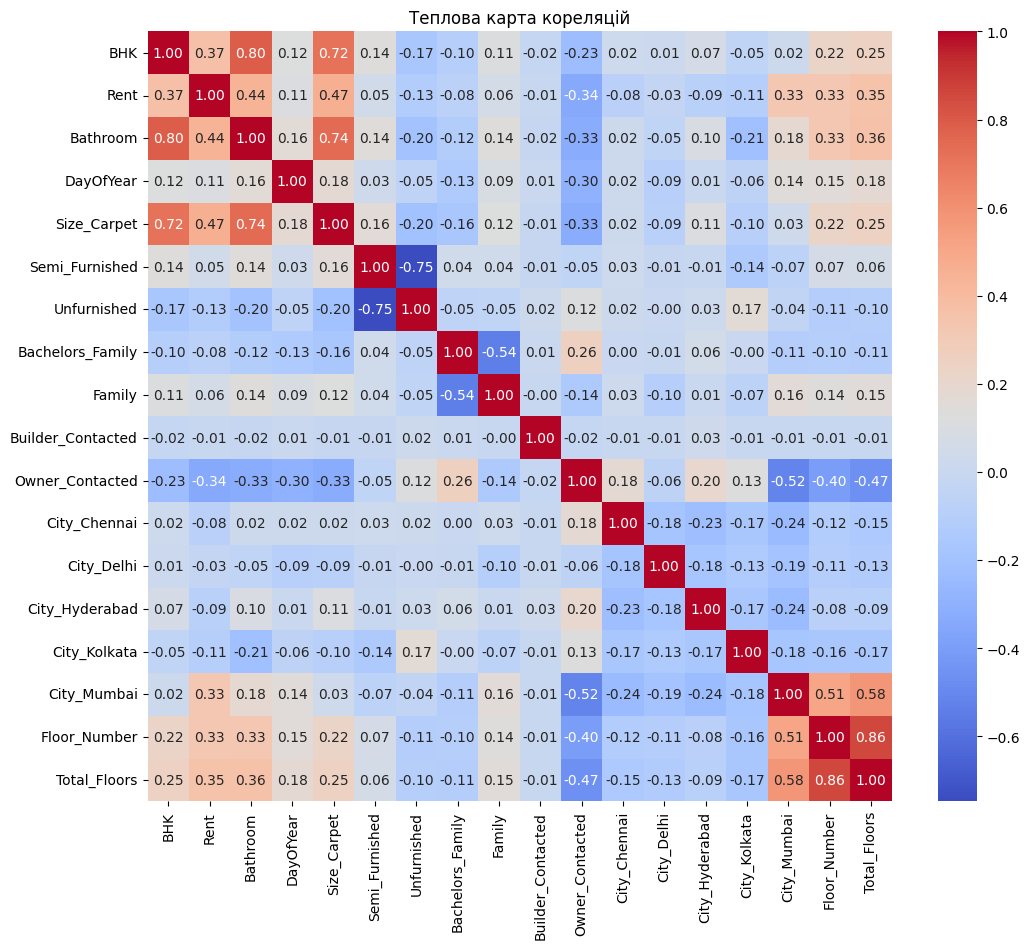

In [337]:
# Візуалізація кореляційної матриці за допомогою теплової карти
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Теплова карта кореляцій")
plt.show()

#### Пояснення кореляційних значень:

У наведених даних зазначено кореляцію різних змінних з цільовою змінною **Rent** (орендна плата). Кореляція показує ступінь і напрямок зв'язку між змінними, де значення варіюється від -1 до 1:

- **1** означає сильний позитивний зв'язок (зростання однієї змінної супроводжується зростанням іншої).
- **-1** означає сильний негативний зв'язок (зростання однієї змінної супроводжується зниженням іншої).
- **0** означає відсутність зв'язку.

##### **Аналіз кореляційних значень**

1. **Size_Carpet (0.466191)**:
   Позитивна кореляція 0.466 свідчить про помірний позитивний зв'язок між розміром *"килимового покриття"* (Size_Carpet) та орендною платою (Rent). Чим більший розмір *"килимового покриття"*, тим вища орендна плата. Це логічно, оскільки більша площа нерухомості зазвичай означає більшу орендну плату.

2. **Bathroom (0.441215)**:
   Кореляція 0.441 означає, що кількість ванних кімнат також має помірний позитивний зв'язок з орендною платою. Більша кількість ванних кімнат часто свідчить про більший і розкішніший житловий простір, що впливає на підвищення орендної плати.

3. **BHK (0.369718)**:
   BHK (спальня, вітальня, кухня) з кореляцією 0.37 також має позитивний зв'язок із орендною платою. Це вказує на те, що квартири з більшою кількістю кімнат, як правило, мають вищу орендну плату.

4. **Total_Floors (0.352268)**:
   Кореляція 0.352 свідчить про те, що загальна кількість поверхів у будівлі має позитивний зв'язок із орендною платою. Будівлі з великою кількістю поверхів часто розташовані у престижних районах або мають кращі зручності, що збільшує вартість оренди.

5. **City_Mumbai (0.327038)**:
   Кореляція 0.327 для міста Мумбаї означає, що розташування нерухомості в цьому місті позитивно впливає на орендну плату. Мумбаї - це одне з найбільш дорогих міст в Індії, що пояснює цей зв'язок.

6. **Floor_Number (0.326200)**:
   Кореляція 0.326 для змінної Floor_Number показує, що розташування на певному поверсі позитивно впливає на орендну плату. Часто вищі поверхи можуть мати кращий вигляд і бути більш популярними, що підвищує вартість оренди.

7. **Contact_Owner (-0.339521)**:
   Негативна кореляція -0.339 для змінної "Contact_Owner" може значити, що при наявності контакту з власником ("Contact_Owner"), орендна плата, ймовірно, буде нижчою. Це може бути пов'язано з тим, що контакт орендара безпосередньо з власником може призвести до зниження посередницької комісії або інших витрат.

Залишимо тільки ті ознаки, які мають кореляцію за модулем більше або рівну 0.3

**Аргументація вибору порогу кореляції**

- Вибір порогу кореляції залежить від конкретної задачі та даних. У цьому випадку ми вибрали поріг 0.33, оскільки він дозволяє відібрати ознаки, які мають помірну або високу кореляцію з цільовою змінною "Rent". Це допоможе підвищити ефективність моделі та зменшити розмірність даних.

- Важливо також враховувати контекст задачі та можливі взаємозв'язки між ознаками. Наприклад, якщо дві ознаки мають високу кореляцію між собою, можливо, варто вибрати лише одну з них для моделювання. Це допоможе уникнути проблеми колінеарності та зберегти інтерпретованість моделі. На тепловій карті кореляцій можна побачити, що деякі ознаки мають високу кореляцію між собою, наприклад, "BHK" та "Bathroom", "Total_Floors" та "Floor_Number". Із цих двох пар вищу кореляцію з цільовою змінною мають **"Bathroom"** (0.441) та **"Total_Floors"** (0.352), тому можна вибрати їх для моделювання. Відповідно, *"BHK"* та *"Floor_Number"* можна виключити.

- Видалення ознак з низькою кореляцією може зменшити розмірність даних, що може поліпшити продуктивність моделі, зменшити час обробки, а також знизити ризик перенавчання (overfitting), а модель з меншою кількістю значущих ознак може бути простішою для інтерпретації та пояснення.

**Ризики такого підходу**
   - Втрата корисної інформації: Кореляція не завжди повністю відображає важливість ознаки. Іноді ознаки з низькою кореляцією можуть мати складніші, нелінійні взаємозв'язки з цільовою змінною або бути важливими у комбінації з іншими ознаками.
   - Можливі колінеарності: Якщо серед ознак залишаться ті, які мають високі кореляції між собою, це може призвести до проблем із колінеарністю (multicollinearity). Це може спотворити вплив окремих ознак на модель і ускладнити інтерпретацію.

**Альтернативні підходи**
   - **Використання методів регуляризації (Regularization):** Методи, такі як Lasso або Ridge, допомагають автоматично "обирати" найважливіші ознаки під час побудови моделі, що може бути більш ефективним, ніж просте фільтрування за кореляцією.
   - **Генерація нових ознак:** Важливо також розглянути можливість генерування нових ознак або використання нелінійних перетворень для виявлення більш складних взаємозв'язків.
   - **Аналіз важливості ознак (Feature Importance):** Використання моделей, які можуть надавати оцінки важливості ознак, таких як Random Forest або Gradient Boosting, дозволяє краще зрозуміти, які ознаки дійсно важливі для прогнозування.

Таким чином, залишення тільки ознак з кореляцією більше або рівною 0.33 за винятком тих, що мають високу кореляцію між собою, може бути розумним підходом для вибору ознак для моделювання. Однак для більш точного та комплексного аналізу можна розглядати інші методи та підходи, які були описані вище.

In [338]:
# Відфільтровуємо ознаки, що мають кореляцію з цільовою змінною Rent більше 0.3 або менше -0.3
target_correlation = correlation_matrix["Rent"]
selected_features = target_correlation[(target_correlation > 0.3) | (target_correlation < -0.3)].index

# Видаляємо "BHK" та "Floor_Number" зі списку відібраних ознак
selected_features = selected_features.drop("BHK")
selected_features = selected_features.drop("Floor_Number")

# Створюємо новий датафрейм з відібраними ознаками
df_filtered = df[selected_features]

# Створюємо оновлену кореляційну матрицю
correlation_matrix = df_filtered.corr()

In [339]:
# Вивід датафрейму з відібраними ознаками
print("\nДані з відібраними ознаками:")
print(df_filtered.head(7))

# Вивід повної кореляційної матриці
print("\nОновлена кореляційна матриця:")
print(correlation_matrix)


Дані з відібраними ознаками:
    Rent  Bathroom  Size_Carpet  Owner_Contacted  City_Mumbai  Total_Floors
0  10000         2        797.5                1            0             2
1  20000         1        580.0                1            0             3
2  17000         1        725.0                1            0             3
3  10000         1        580.0                1            0             2
4   7500         1        850.0                1            0             2
5   7000         2        435.0                1            0             1
6  10000         2        507.5                0            0             4

Оновлена кореляційна матриця:
                     Rent  Bathroom  Size_Carpet  Owner_Contacted  \
Rent             1.000000  0.440976     0.466059        -0.339370   
Bathroom         0.440976  1.000000     0.744226        -0.327592   
Size_Carpet      0.466059  0.744226     1.000000        -0.327697   
Owner_Contacted -0.339370 -0.327592    -0.327697       

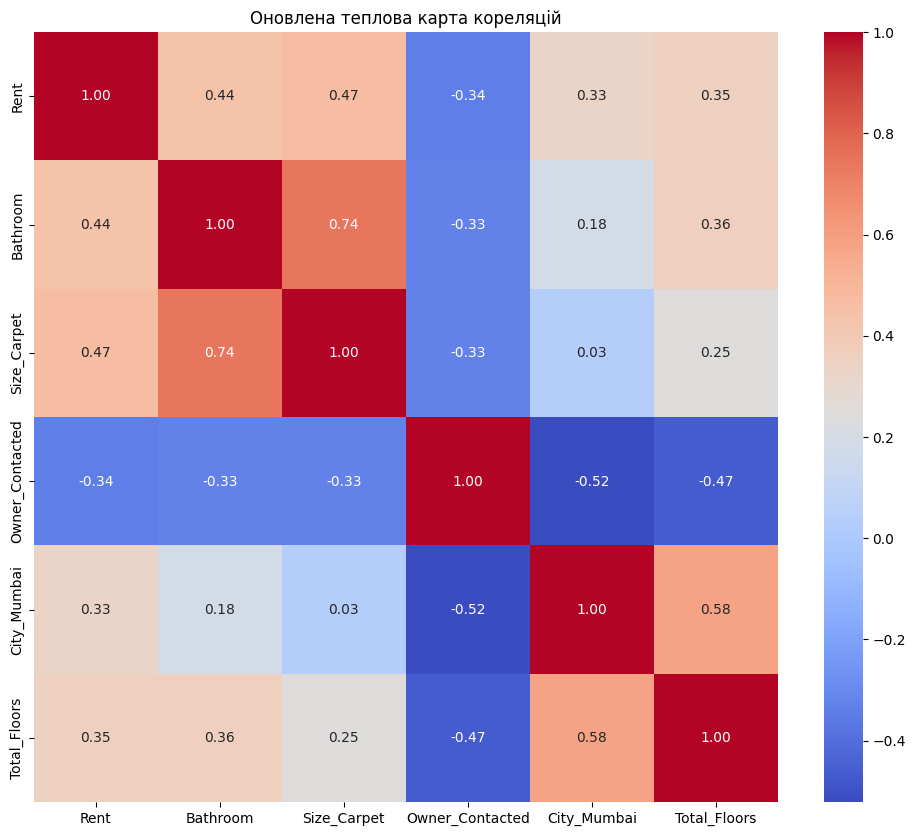

In [340]:
# Візуалізація оновленої кореляційної матриці за допомогою теплової карти
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Оновлена теплова карта кореляцій")
plt.show()

Побудуємо boxplot та гістограми для ознак, що мають найбільшу кореляцію з цільовою змінною, для візуального аналізу розподілу даних та виявлення викидів.

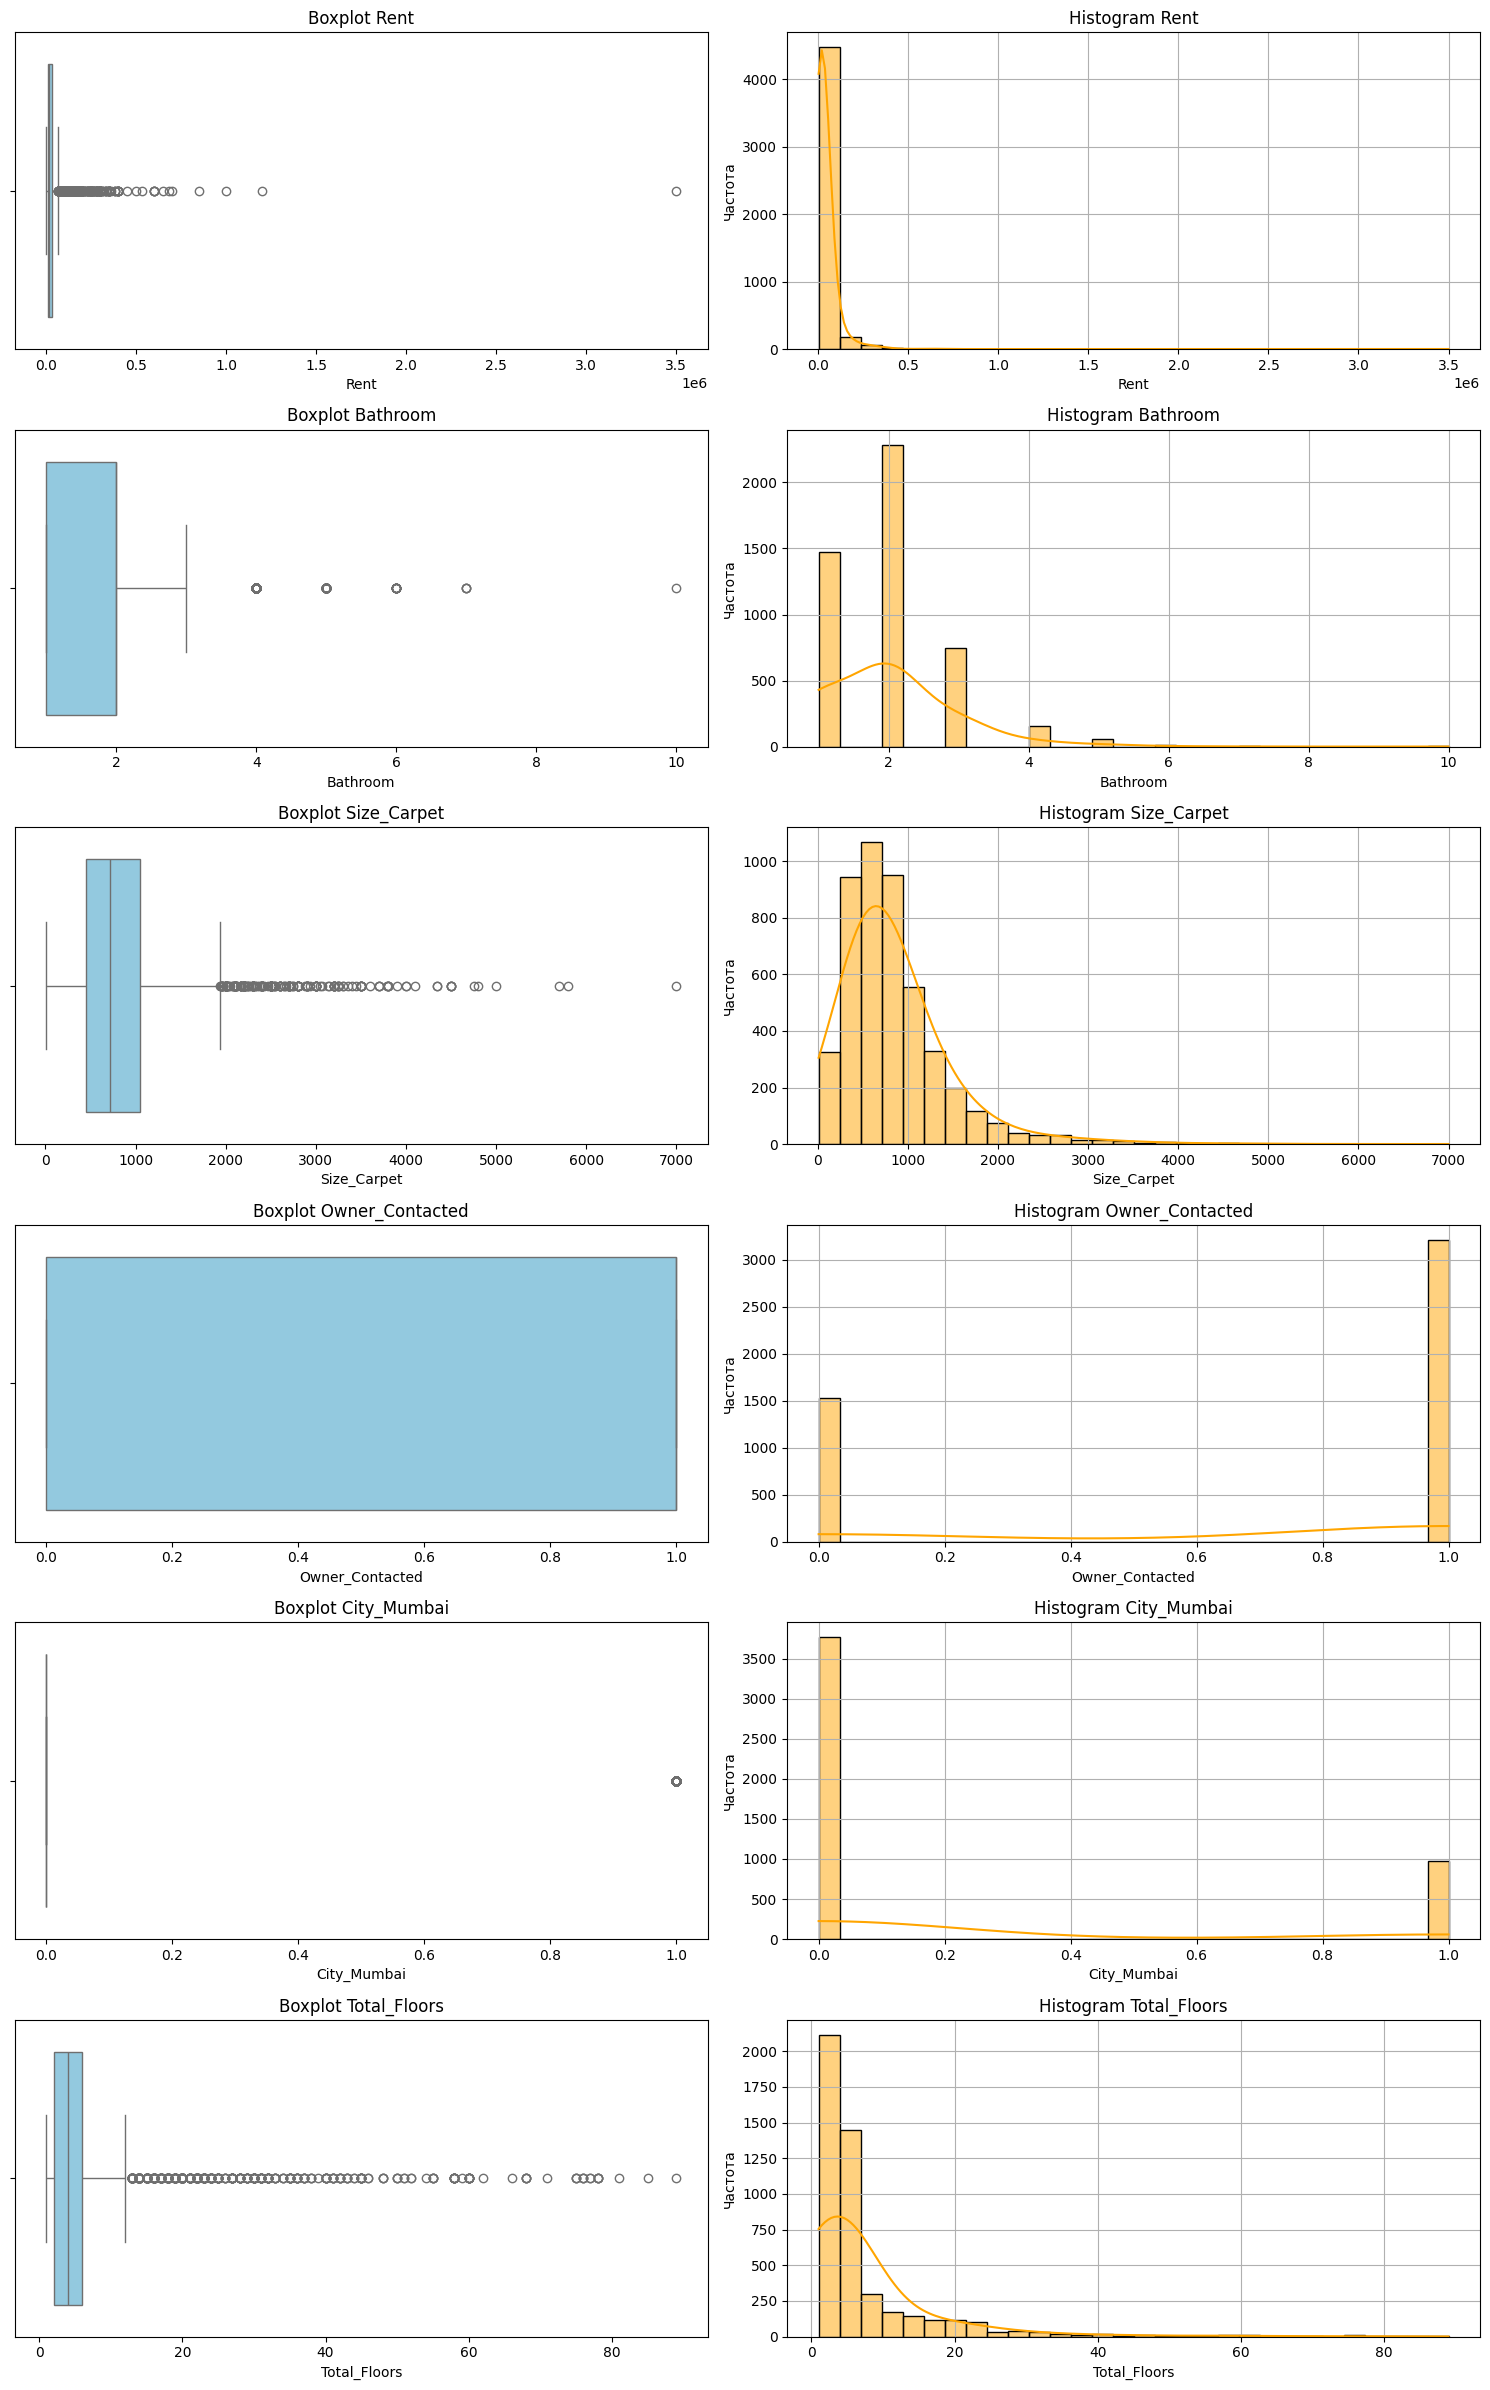

In [341]:
num_columns = len(df_filtered.columns)

# Налаштування графіків
plt.figure(figsize=(15, num_columns * 4))  # Регулюємо розмір вікна залежно від кількості ознак

for i, column in enumerate(df_filtered.columns):
    # Створюємо subplot з двома графіками поруч
    plt.subplot(num_columns, 2, 2 * i + 1)
    sns.boxplot(x=df_filtered[column], color='skyblue')
    plt.title(f'Boxplot {column}')
    
    plt.subplot(num_columns, 2, 2 * i + 2)
    sns.histplot(df_filtered[column], bins=30, kde=True, kde_kws={"bw_adjust": 3}, color='orange', edgecolor='black')
    plt.title(f'Histogram {column}')
    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.grid(True)

plt.tight_layout()  # Автоматичне вирівнювання графіків
plt.show()

#### Видалення викидів
Привертає до себе увагу boxplot для цільової змінної "Rent", де можна розпізнати викиди.

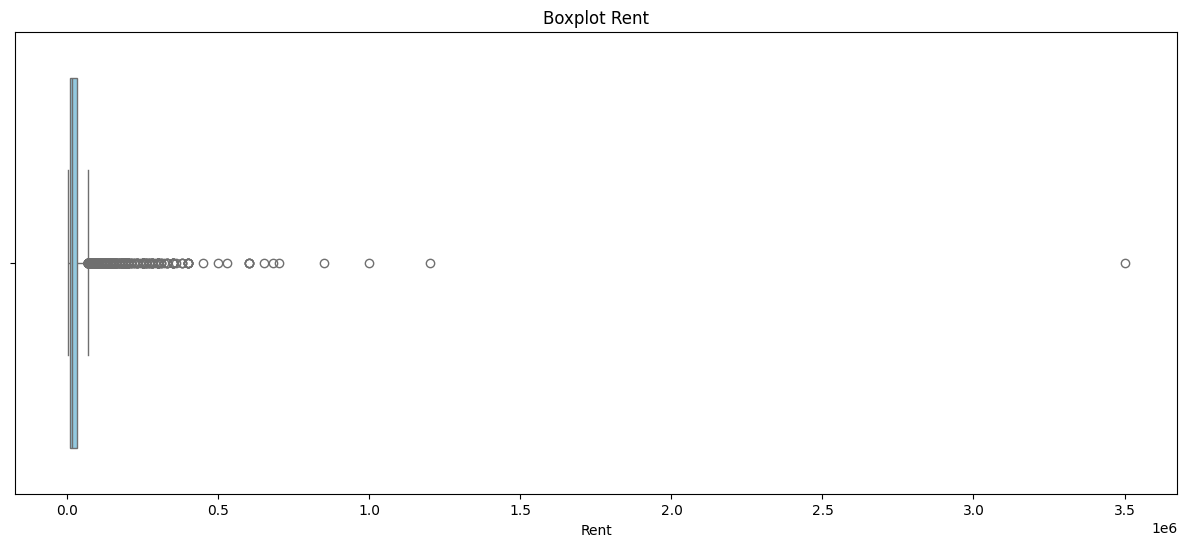

In [342]:
# Виведемо boxplot для ознаки "Rent"
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_filtered['Rent'], color='skyblue')
plt.title('Boxplot Rent')
plt.show()

Попри невелику кількість викидів, вони можуть вплинути на результати моделювання, тому важливо вирішити, як їх обробити. Це може включати видалення викидів, заміну їх на інші значення або використання методів, які є менш чутливими до викидів, таких як дерева рішень або методи, що використовують ранги.
На цьому етапі можна використати методи видалення викидів, для усунення аномальних значень та покращення якості даних для моделювання.

Кількість видалених рядків: -1


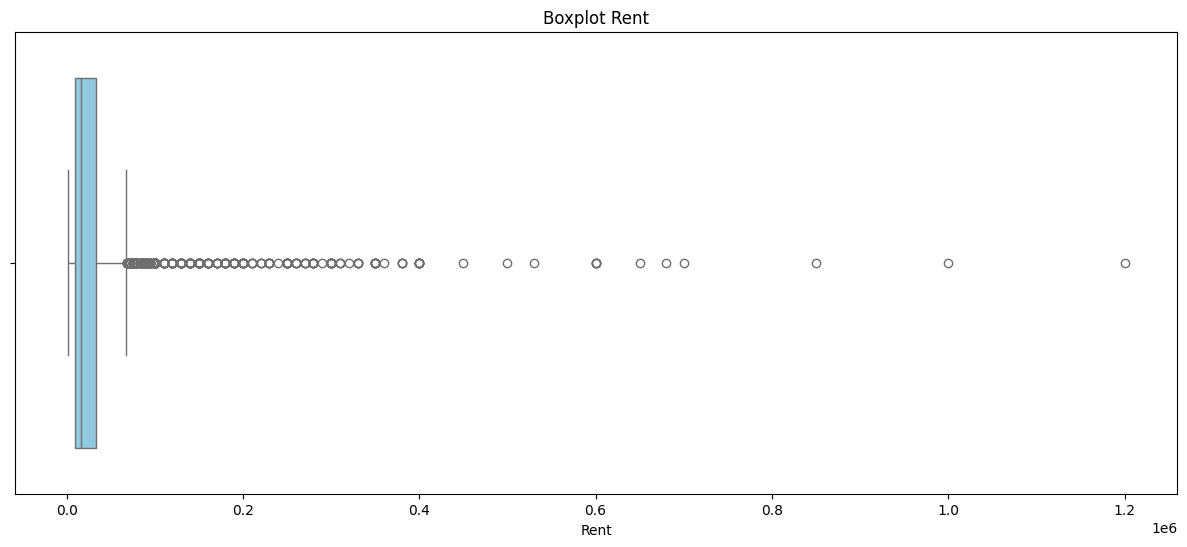

In [343]:
# Визначення порогу для 99.99% перцентиля
threshold = df_filtered['Rent'].quantile(0.9999)

# Фільтрація даних: залишаємо лише ті значення, що знаходяться в межах "вусів"
df = df_filtered[(df_filtered['Rent'] <= threshold)]

# Перевірка кількості видалених рядків
removed_rows = len(df) - len(df_filtered)
print(f"Кількість видалених рядків: {removed_rows}")

# Повторно виведемо boxplot для ознаки "Rent"
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['Rent'], color='skyblue')
plt.title('Boxplot Rent')
plt.show()

## **ЧАСТИНА 2: *Моделювання***

### Лінійна регресія

In [344]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


# Розділення даних на ознаки та цільову змінну
X = df.drop("Rent", axis=1)
y = df["Rent"]

# Розділення на навчальну та тестову вибірки (80% навчання, 20% тестування)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [345]:
# Створення та навчання моделі лінійної регресії
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# Обчислення метрик для лінійної регресії
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)
r2_linreg = r2_score(y_test, y_pred_linreg)

# Виведення результатів лінійної регресії
print("Результати лінійної регресії:")
print(f"MSE: {mse_linreg:.2f}")
print(f"MAE: {mae_linreg:.2f}")
print(f"R²: {r2_linreg:.2f}")


Результати лінійної регресії:
MSE: 966950554.20
MAE: 20864.41
R²: 0.57


### Random Forest

In [346]:
# Створення та навчання моделі RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Обчислення метрик для Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Виведення результатів RandomForest
print("Результати Random Forest:")
print(f"MSE: {mse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.2f}")


Результати Random Forest:
MSE: 577738542.64
MAE: 10961.16
R²: 0.75


### Random Forest з використанням GridSearchCV

In [347]:
from sklearn.model_selection import GridSearchCV

# Визначаємо параметри, які ми хочемо налаштувати (гіперпараметри)
# n_estimators: кількість дерев у лісі
# max_depth: максимальна глибина кожного дерева
# min_samples_split: мінімальна кількість зразків, необхідна для розщеплення вузла
# min_samples_leaf: мінімальна кількість зразків, необхідна для утворення листа
param_grid = {
    'n_estimators': [100, 200, 300],  # Досліджуємо 3 різні кількості дерев
    'max_depth': [None, 10, 20, 30],  # Без обмежень на глибину та 3 конкретні значення
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Ініціалізуємо модель RandomForestRegressor (ліс рішень для регресії)
# random_state=42 забезпечує відтворюваність результатів, оскільки це фіксує "випадковість"
rf = RandomForestRegressor(random_state=42)

# Ініціалізуємо GridSearchCV для перебору різних комбінацій параметрів
# cv=5 означає використання 5-кратної крос-валідації (дані діляться на 5 частин)
# n_jobs=-1 означає використання всіх доступних процесорів для прискорення обчислень
# verbose=2 дозволяє виводити докладну інформацію про хід виконання
# scoring='neg_mean_squared_error' задає метрику оцінки моделі (негативна середньоквадратична помилка)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Навчаємо GridSearchCV на тренувальних даних
# Підбирається найкраща комбінація параметрів для моделі RandomForest
grid_search.fit(X_train, y_train)

# Використовуємо найкращу модель (найкращі параметри) для прогнозування на тестових даних
best_rf = grid_search.best_estimator_  # Отримуємо модель з найкращими параметрами
y_pred = best_rf.predict(X_test)       # Прогнозуємо значення для тестового набору


# Обчислення метрик для Random Forest з GridSearchCV
mse_rf_gs = mean_squared_error(y_test, y_pred_rf_gs)
mae_rf_gs = mean_absolute_error(y_test, y_pred_rf_gs)
r2_rf_gs = r2_score(y_test, y_pred_rf_gs)

# Виведення результатів Random Forest з GridSearchCV
print("Результати Random Forest з GridSearchCV:")
print(f"MSE: {mse_rf_gs:.2f}")
print(f"MAE: {mae_rf_gs:.2f}")
print(f"R²: {r2_rf_gs:.2f}")
print()

# Виводимо найкращі параметри, знайдені GridSearchCV
print("Найкращі параметри:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END m

## ЧАСТИНА 3. Аналіз результатів

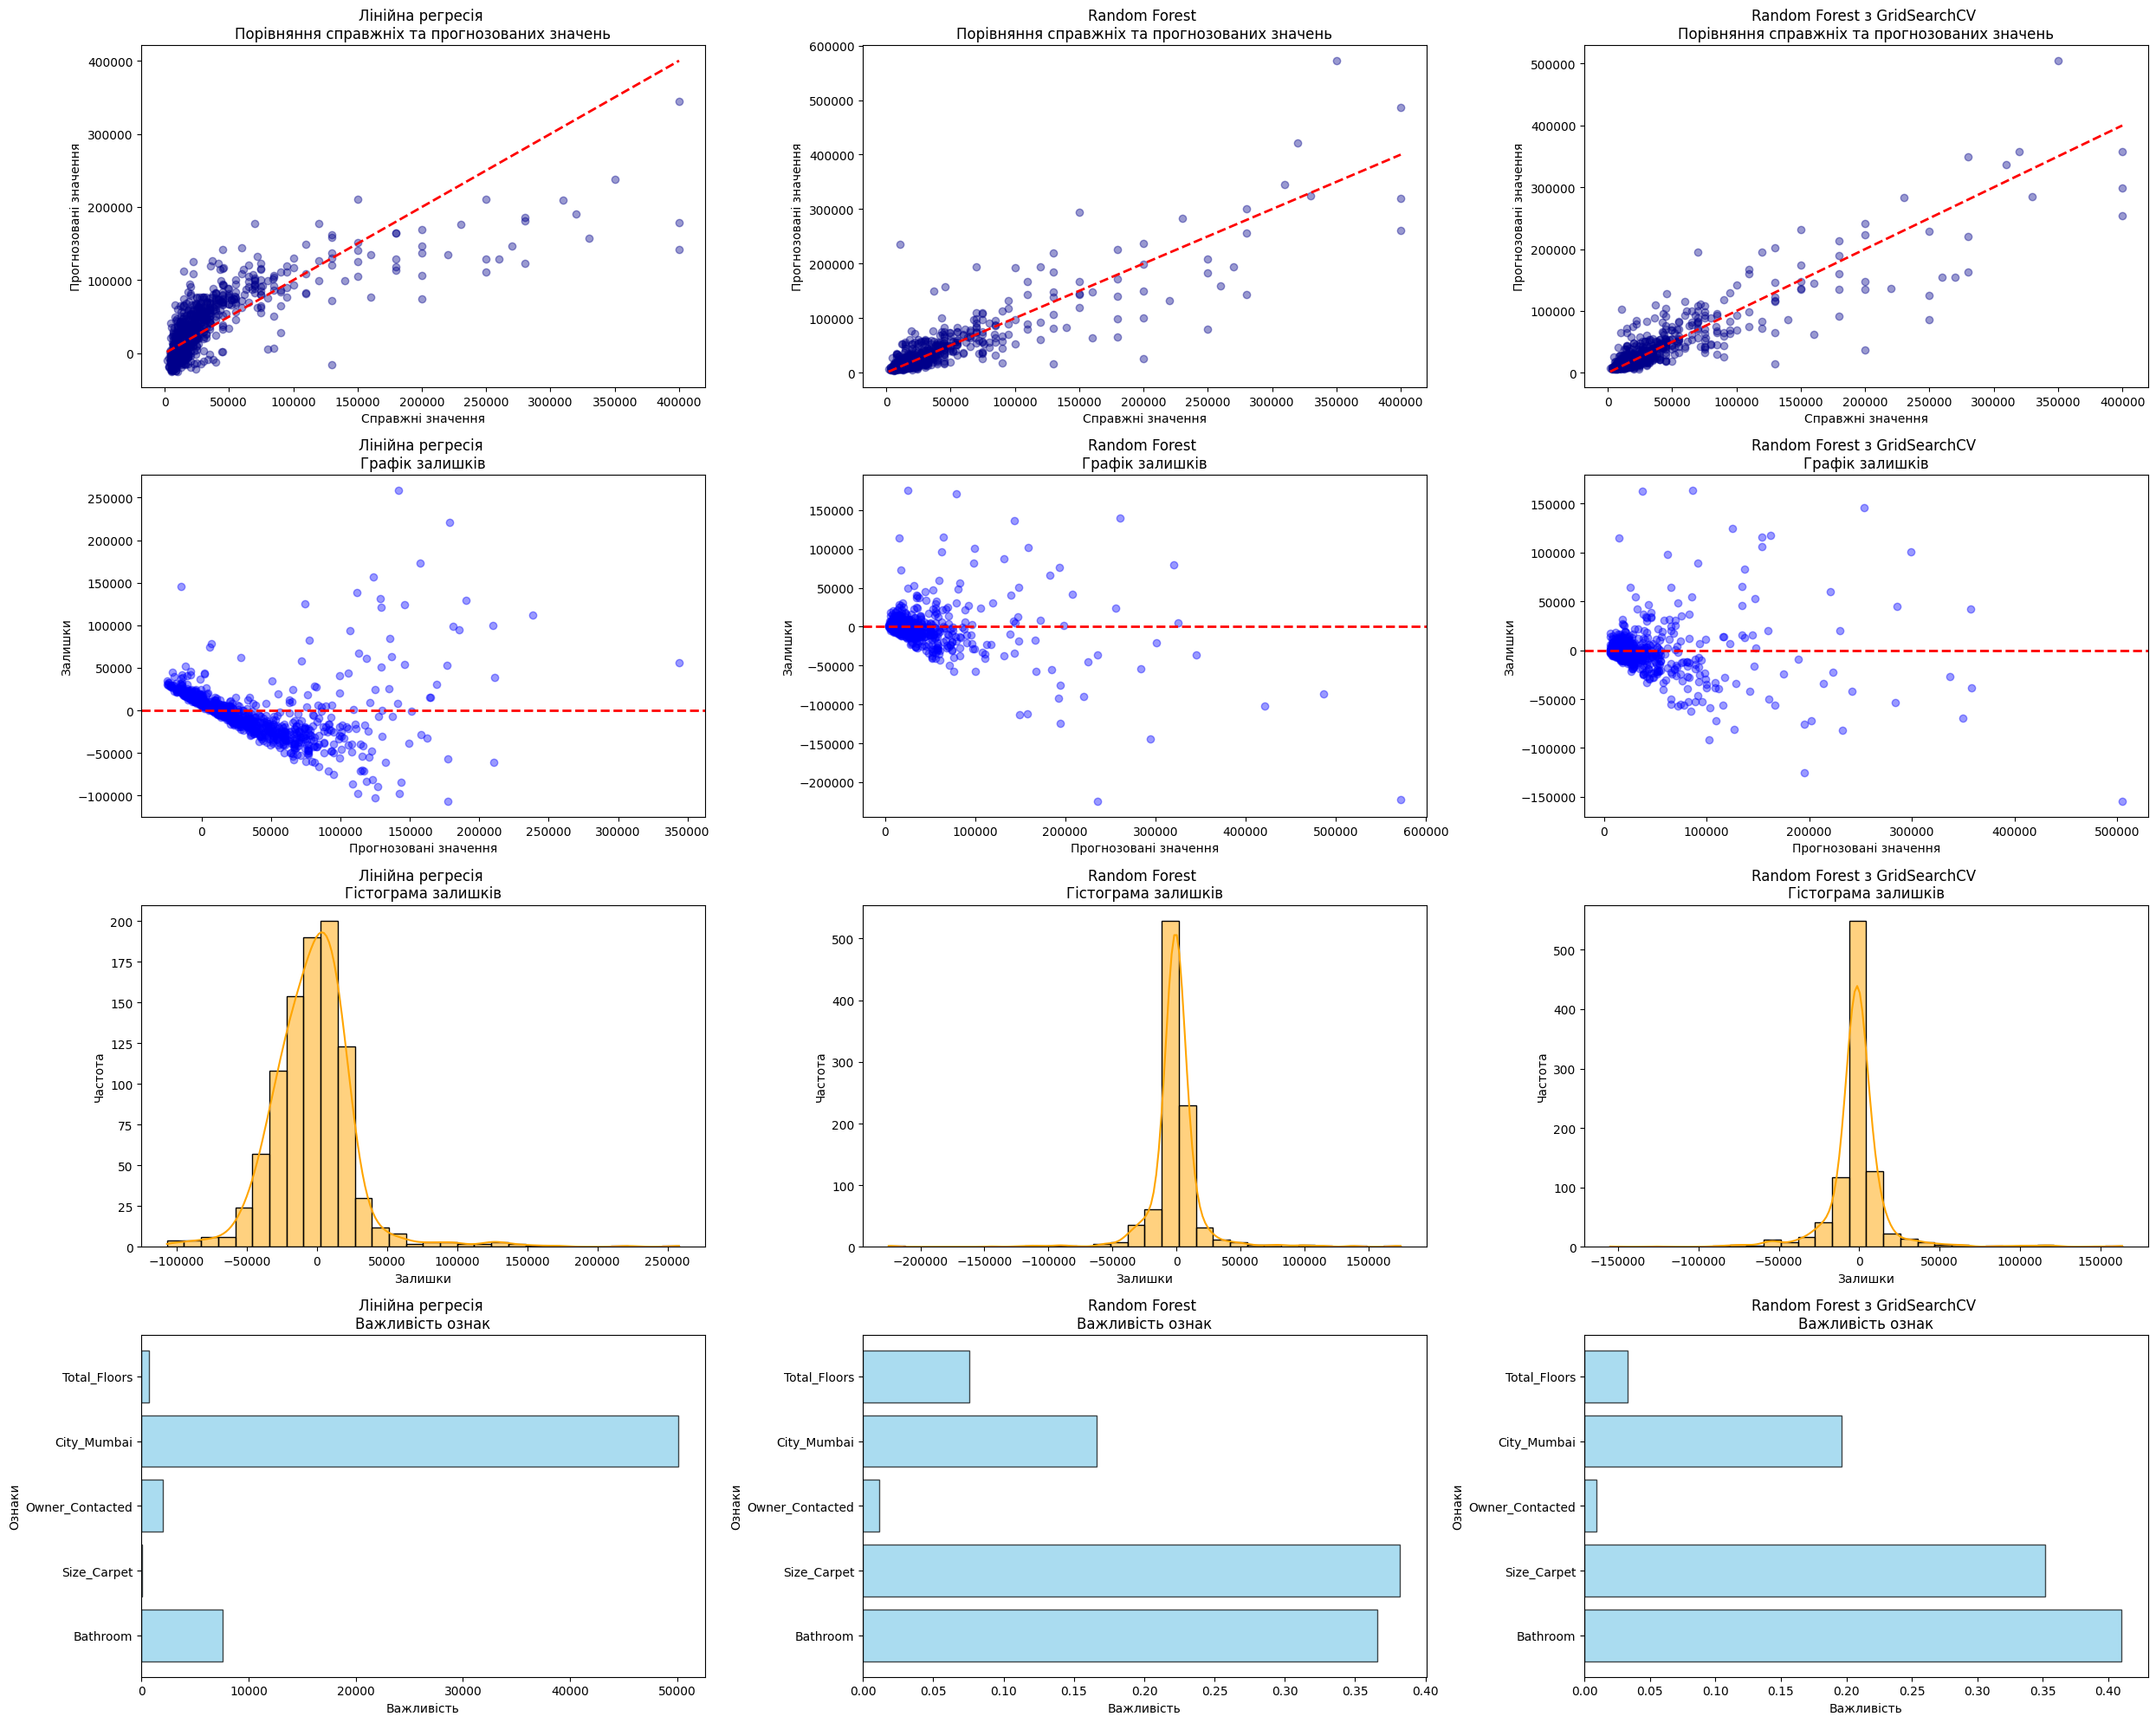

In [348]:
# Моделі та результати
models = ["Лінійна регресія", "Random Forest", "Random Forest з GridSearchCV"]
y_preds = {
    "Лінійна регресія": y_pred_linreg,
    "Random Forest": y_pred_rf,
    "Random Forest з GridSearchCV": y_pred_rf_gs
}
residuals = {model: y_test - y_pred for model, y_pred in y_preds.items()}
feature_importance = {
    "Лінійна регресія": np.abs(linreg.coef_),
    "Random Forest": rf_model.feature_importances_,
    "Random Forest з GridSearchCV": best_rf.feature_importances_
}
features = X.columns

# Створення графіків
fig, axes = plt.subplots(4, 3, figsize=(25, 20))
axes = axes.flatten()

# Порівняння справжніх та прогнозованих значень
for i, model in enumerate(models):
    axes[i].scatter(y_test, y_preds[model], color='darkblue', alpha=0.4)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', lw=2)
    axes[i].set_title(f'{model} \nПорівняння справжніх та прогнозованих значень')
    axes[i].set_xlabel('Справжні значення')
    axes[i].set_ylabel('Прогнозовані значення')

# Графіки залишків
for i, model in enumerate(models):
    axes[i+3].scatter(y_preds[model], residuals[model], color='blue', alpha=0.4)
    axes[i+3].axhline(0, color='red', linestyle='--', lw=2)
    axes[i+3].set_title(f'{model} \nГрафік залишків')
    axes[i+3].set_xlabel('Прогнозовані значення')
    axes[i+3].set_ylabel('Залишки')

for i, model in enumerate(models):
    # Гістограма залишків
    sns.histplot(residuals[model], bins=30, kde=True, kde_kws={"bw_adjust": 1}, color='orange', edgecolor='black', ax=axes[i+6])
    axes[i+6].set_title(f'{model} \nГістограма залишків')
    axes[i+6].set_xlabel('Залишки')
    axes[i+6].set_ylabel('Частота')

# Важливість ознак
for i, model in enumerate(models):
    axes[i+9].barh(features, feature_importance[model], color='skyblue', alpha=0.7, edgecolor='black')
    axes[i+9].set_title(f'{model} \nВажливість ознак')
    axes[i+9].set_xlabel('Важливість')
    axes[i+9].set_ylabel('Ознаки')


plt.tight_layout()
plt.show()


### Порівняння якості моделей та аналіз помилок

#### 1. **Порівняння якості моделей**

Для оцінки якості моделей ми використали три основні метрики: Mean Squared Error (MSE), Mean Absolute Error (MAE) та R-squared (R²). Ці метрики дозволяють порівнювати точність моделей на основі їхніх прогнозів:

- **Лінійна регресія**:
  - **MSE**: 966,950,554.20
  - **MAE**: 20,864.41
  - **R²**: 0.57
  - **Висновок**: Лінійна регресія показала середню якість прогнозування з помітними помилками. MSE та MAE досить високі, що вказує на значні похибки у прогнозах. Значення R² показує, що модель пояснює лише 57% варіації в даних.

- **Random Forest (без оптимізації)**:
  - **MSE**: 577,738,542.64
  - **MAE**: 10,961.16
  - **R²**: 0.75
  - **Висновок**: Використання Random Forest значно покращило результати. MSE знизився, а R² зріс до 0.75, що вказує на те, що модель пояснює 75% варіації в даних. MAE також значно знизився, що вказує на те, що середні абсолютні помилки стали меншими.

- **Random Forest (з GridSearchCV)**:
  - **MSE**: 465,360,161.27
  - **MAE**: 10,519.01
  - **R²**: 0.80
  - **Висновок**: Оптимізація гіперпараметрів через GridSearchCV ще більше покращила результати. Значення R² показує, що модель тепер пояснює 80% варіації в даних, що є значним покращенням. MAE та MSE також знизились, що означає, що модель стала більш точною.

#### 2. **Аналіз помилок**

Щоб зрозуміти, на яких прикладах кожна модель більше помиляється, ми можемо порівняти справжні та прогнозовані значення. 

- **Лінійна регресія**:
  - Ця модель є найбільш схильною до помилок на прикладах, де залежність між ознаками і цільовою змінною є нелінійною. Вона може добре працювати на простих лінійних залежностях, але значно помиляється на більш складних, особливо коли є впливи кількох змінних.

- **Random Forest (без оптимізації)**:
  - Ця модель краще враховує нелінійні залежності, але може допускати помилки на прикладах, де спостерігаються складні взаємодії між змінними. Наприклад, вона може переоцінювати або недооцінювати вплив окремих ознак через обмеження глибини дерева або кількості дерев у лісі.

- **Random Forest (з GridSearchCV)**:
  - Оптимізована модель найкраще підходить для прогнозування на більшості прикладів. Вона більш точно враховує складні залежності та взаємодії між ознаками. Однак, навіть ця модель може допускати помилки на прикладах з дуже складними, рідкісними або непередбачуваними даними, де випадкові фактори сильно впливають на результати.

#### 3. **Загальний висновок**

Результати показують, що модель Random Forest з оптимізованими гіперпараметрами за допомогою GridSearchCV є найкращим вибором для прогнозування цін оренди нерухомості в цьому наборі даних. Ця модель змогла найбільш ефективно врахувати нелінійні залежності та взаємодії між ознаками, що дозволило значно зменшити помилки у прогнозах.

Однак, навіть найкраща модель може мати свої обмеження, особливо на нестандартних або рідкісних даних. Тому важливо враховувати специфіку набору даних, на якому працює модель, та продовжувати вдосконалювати методи обробки та моделювання для досягнення ще кращих результатів.